In [1]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())



In [2]:
# import tensorflow as tf
# print("TensorFlow version:", tf.__version__)
# print("GPUs:", tf.config.list_physical_devices('GPU'))


In [3]:
# import os
# os.add_dll_directory(r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cublas\bin")
# os.add_dll_directory(r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cuda_runtime\bin")
# os.add_dll_directory(r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cudnn\bin")
# os.add_dll_directory(r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cuda_nvrtc\bin")


In [4]:
# import tensorflow as tf
# print("GPUs:", tf.config.list_physical_devices('GPU'))



In [5]:
# import os
# import tensorflow as tf

# # Add the DLL directories from your venv
# cuda_dirs = [
#     r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cublas\bin",
#     r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cuda_runtime\bin",
#     r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cudnn\bin",
#     r"C:\Academics\CS courses\CSC-338\ML\venv\Lib\site-packages\nvidia\cuda_nvrtc\bin"
# ]

# for d in cuda_dirs:
#     os.add_dll_directory(d)

# # Check GPU detection
# print("TensorFlow version:", tf.__version__)
# gpus = tf.config.list_physical_devices('GPU')
# print("GPUs detected:", gpus)

# # Optional: detailed info
# if gpus:
#     for gpu in gpus:
#         print(tf.config.experimental.get_device_details(gpu))


This network uses a hybrid architecture combining several modern techniques:

1. Inception Modules - Multi-scale feature extraction through parallel 
   convolutional paths of different kernel sizes. This allows the network
   to capture patterns at multiple scales simultaneously.

2. Residual Connections - Skip connections that help gradients flow through
   deep networks and allow the network to learn residual mappings.

3. Squeeze-and-Excitation Blocks - Channel attention mechanism that learns
   to weight feature channels based on their importance for the task.

4. Dense Connections - Cross-stage connections that allow features from
   earlier layers to directly influence later layers, improving gradient
   flow and feature reuse.

5. Dual Attention - Combined spatial and channel attention in the final
   stages to focus on important regions and features.

6. Multi-Scale Pooling - Uses both average and max pooling to capture
   different statistical properties of the feature maps.

The architecture processes features through three main stages with 
progressively increasing complexity and abstraction. Early stages use
inception modules for multi-scale processing, middle stages use residual
learning, and late stages apply attention mechanisms before classification.

In [6]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **Test** set within 30 epochs.

In [7]:
# Load CIFAR-10 dataset
(x_train0, y_train0), (x_test0, y_test0) = tf.keras.datasets.cifar10.load_data()

In [8]:

# Normalize pixel values to [0, 1]
x_train = x_train0.reshape(50000, 32, 32, 3).astype("float32") / 255.0
x_test = x_test0.reshape(10000, 32, 32, 3).astype("float32") / 255.0
y_train = np.asarray(y_train0, dtype=np.int32)
y_test = np.asarray(y_test0, dtype=np.int32)

In [9]:
def inception_block(x, filters):
    # Inception module with 4 parallel paths for multi-scale feature extraction
    
    # Path 1: 1x1 convolution for dimensionality reduction
    path1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    
    # Path 2: 1x1 reduction followed by 3x3 convolution
    path2 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(path2)
    
    # Path 3: 1x1 reduction followed by two 3x3 convolutions (simulates 5x5)
    path3 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(path3)
    path3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(path3)
    
    # Path 4: Max pooling followed by 1x1 convolution
    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(path4)
    
    # Concatenate all paths along the channel dimension
    return layers.Concatenate()([path1, path2, path3, path4])

In [10]:
def residual_block(x, filters):
    # Residual block with skip connection for gradient flow
    shortcut = x
    
    # Main path: two conv layers with batch normalization
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add shortcut to main path and apply activation
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [11]:
def squeeze_excitation_block(x, ratio=16):
    # Channel attention mechanism using squeeze-and-excitation
    channels = x.shape[-1]
    
    # Squeeze: global spatial information into channel descriptor
    se = layers.GlobalAveragePooling2D()(x)
    
    # Excitation: learn channel-wise weights
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    
    # Scale: apply learned weights to input
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([x, se])

In [12]:
def MyNet():
    # architecture combining inception, residual, and attention mechanisms
    
    inputs = layers.Input(shape=(32, 32, 3))
    
    # Data augmentation applied during training only
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.15)(x)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomContrast(0.2)(x)
    
    # Initial feature extraction
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Stage 1: Multi-scale feature extraction at 32x32 resolution
    inception1 = inception_block(x, 16)
    inception1 = layers.BatchNormalization()(inception1)
    inception1 = layers.Dropout(0.2)(inception1)
    
    residual1 = residual_block(inception1, 64)
    se1 = squeeze_excitation_block(residual1)
    
    # Reduce spatial dimensions to 16x16
    x = layers.MaxPooling2D((2, 2))(se1)
    
    # Stage 2: Deeper feature learning at 16x16 resolution
    inception2 = inception_block(x, 24)
    inception2 = layers.BatchNormalization()(inception2)
    inception2 = layers.Dropout(0.3)(inception2)
    
    residual2 = residual_block(inception2, 96)
    se2 = squeeze_excitation_block(residual2)
    
    # Dense connection: add features from stage 1 to stage 2
    se1_pooled = layers.MaxPooling2D((2, 2))(se1)
    se1_adjusted = layers.Conv2D(96, (1, 1), padding='same')(se1_pooled)
    dense_concat1 = layers.Add()([se2, se1_adjusted])
    
    # Reduce spatial dimensions to 8x8
    x = layers.MaxPooling2D((2, 2))(dense_concat1)
    
    # Stage 3: Deep feature processing at 8x8 resolution
    residual3a = residual_block(x, 128)
    residual3a = layers.Dropout(0.35)(residual3a)
    
    residual3b = residual_block(residual3a, 128)
    se3 = squeeze_excitation_block(residual3b)
    
    # Dual attention mechanism for comprehensive feature refinement
    # Path A: spatial attention to focus on important regions
    spatial_attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(se3)
    spatial_features = layers.Multiply()([se3, spatial_attention])
    
    # Path B: additional channel-wise transformation
    channel_features = layers.Conv2D(128, (1, 1), activation='relu')(se3)
    
    # Combine both attention paths
    x = layers.Concatenate()([spatial_features, channel_features])
    x = layers.Conv2D(256, (1, 1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    # Final feature compression
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Multi-scale global pooling to capture both average and max activations
    gap = layers.GlobalAveragePooling2D()(x)
    gmp = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([gap, gmp])
    
    # Classification head
    x = layers.Dense(384, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(192, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [13]:
# Create and display model
model = MyNet()
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")

# Setup training callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
]

# Train the model
print("\nStarting training...")
training_history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Save the trained model (AFTER training)
print("\nSaving model...")
model.save('my_trained_model.keras')
print("Model saved successfully!")

# Optional: Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 32, 32, 3) │          0 │ input_layer[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 32, 32, 3) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 32, 32, 3) │          0 │ random_rotation[… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 32, 32, 3) │          0 │ random_zoom[0][0] │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ random_contrast[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        528 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        528 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      2,320 │ conv2d_4[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │        528 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      2,320 │ conv2d_5[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │        528 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_1[0][0],   │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]  

 Total params: 1,611,445 (6.15 MB)

 Trainable params: 1,607,093 (6.13 MB)

 Non-trainable params: 4,352 (17.00 KB)


Total parameters: 1,611,445

Starting training...
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 243ms/step - accuracy: 0.2853 - loss: 2.0695 - val_accuracy: 0.2340 - val_loss: 2.1695 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 249ms/step - accuracy: 0.4376 - loss: 1.5661 - val_accuracy: 0.4332 - val_loss: 1.5698 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 161s 257ms/step - accuracy: 0.5005 - loss: 1.3801 - val_accuracy: 0.5210 - val_loss: 1.3909 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.5560 - loss: 1.2499 - val_accuracy: 0.5469 - val_loss: 1.2735 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 272ms/step - accuracy: 0.5892 - loss: 1.1676 - val_accuracy: 0.5120 - val_loss: 1.3742 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 241ms/step - accuracy: 0.6192 - loss: 1.0909 - val_accuracy: 0.5476 - val_loss: 1.2990 - learning_rate: 0.0010
Epoch 7/30
62


TRAINING HISTORY


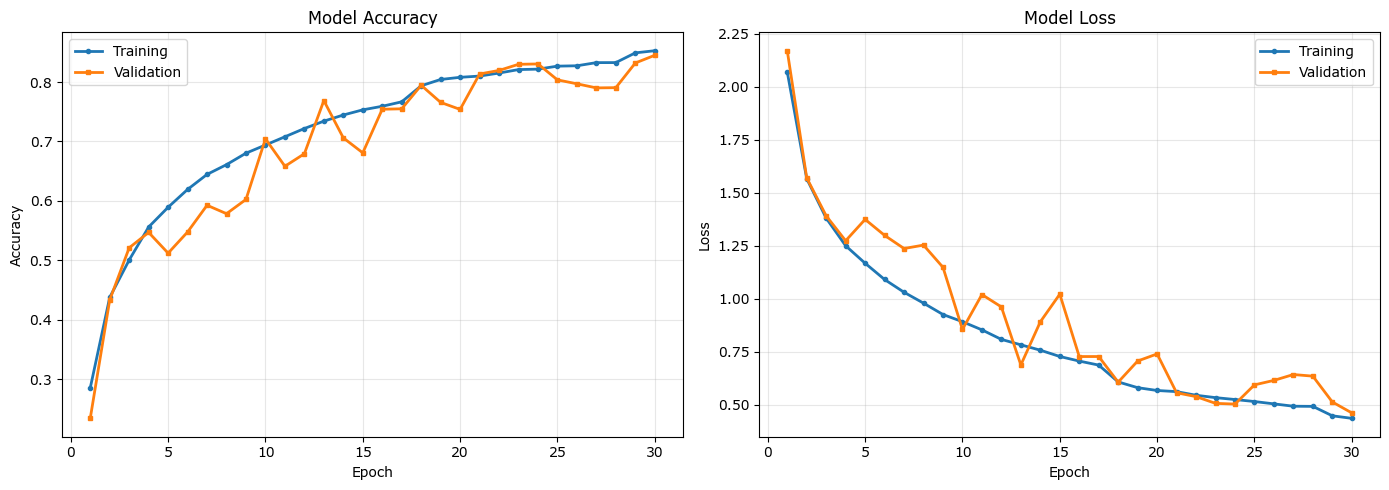

In [14]:
# Plot training curves
print("\n" + "="*70)
print("TRAINING HISTORY")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(training_history.history['accuracy']) + 1)

# Accuracy plot
ax1.plot(epochs_range, training_history.history['accuracy'], 
         label='Training', linewidth=2, marker='o', markersize=3)
ax1.plot(epochs_range, training_history.history['val_accuracy'], 
         label='Validation', linewidth=2, marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(epochs_range, training_history.history['loss'], 
         label='Training', linewidth=2, marker='o', markersize=3)
ax2.plot(epochs_range, training_history.history['val_loss'], 
         label='Validation', linewidth=2, marker='s', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Model Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()


In [15]:
# Evaluate on test set
print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")




TEST SET PERFORMANCE

Test Loss: 0.4675
Test Accuracy: 84.48%



SAMPLE PREDICTIONS


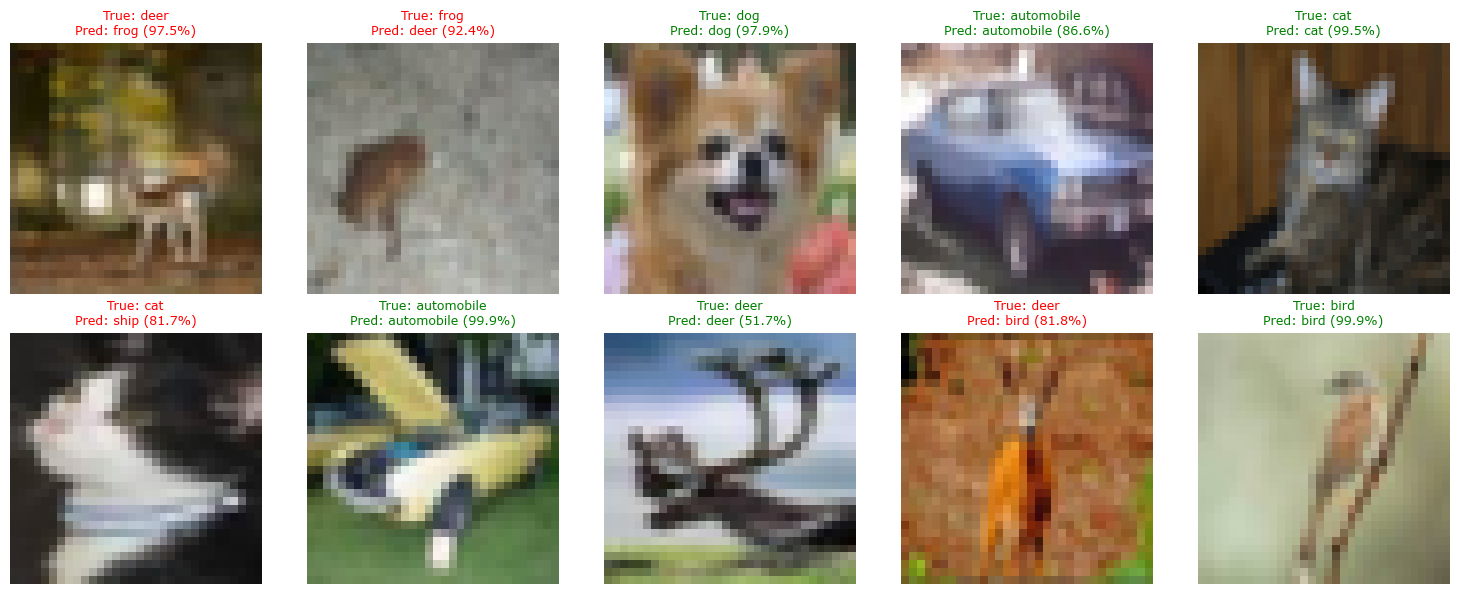


Training complete.
Final test accuracy: 84.48%
Total parameters: 1,611,445


In [16]:
# Sample predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, len(x_test))
    prediction = model.predict(x_test[idx:idx+1], verbose=0)
    pred_label = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    true_label = y_test[idx][0]
    
    axes[i].imshow(x_test0[idx])
    axes[i].axis('off')
    
    # Color code correct vs incorrect predictions
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.1f}%)',
                     color=color, fontsize=9)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150)
plt.show()

print("\nTraining complete.")
print(f"Final test accuracy: {test_accuracy*100:.2f}%")
print(f"Total parameters: {model.count_params():,}")

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the saved model
model = load_model('my_trained_model.keras')

# Display directly in notebook
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [18]:
# for i, img in enumerate(x_test0[0:64]):
#     plt.subplot(8, 8, i+1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
#     #prediction = model.predict(x_test[i:i+1])
#     #pred_label = np.argmax(prediction)
    
   
#     plt.tight_layout()

In [19]:
# def MyNet():
#     # your code here
#     model = tf.keras.Sequential([
       
#     ])
#     # you can modify the optimizer as needed
#     model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
#     return model

  

In [20]:
# model = MyNet()
# training_history = model.fit(x_train, y_train, epochs=10)

In the cell below:  

1) Plot the network diagram
2) Write an explanation of what you did
3) Plot the loss and accuracy graph over epoches
4) Report accuracy on Test dataset. 